In [1]:
#저장:현재 작업 디렉토리
import os
SAVE_DIR = '.'
current_directory = os.getcwd()
print(current_directory)

/content


# 프루닝된 모델 로드

In [6]:
# 1. 필요한 라이브러리 설치 및 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import datasets, transforms
from torchvision.models import vgg16_bn
import matplotlib.pyplot as plt
import os

# 2. 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3. 데이터셋 로드 (CIFAR-100)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

#4, 프루닝된 모델 로드
def load_pruned_model_with_plan(model_path, device):
    """Pruning plan을 사용하여 프루닝된 모델을 정확히 재구성하고 로드"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    state_dict = checkpoint['model_state_dict']
    pruning_plan = checkpoint.get('pruning_plan', None)

    print(f"\n{model_path} 로드 중...")

    if pruning_plan is None:
        raise ValueError("pruning_plan이 checkpoint에 없습니다. 다시 프루닝을 수행하세요.")

    # 기본 VGG16 구조 생성
    model = vgg16_bn(weights=None)

    # Conv 레이어 인덱스 파악
    conv_indices = []
    bn_indices = []
    for i, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):
            conv_indices.append(i)
            bn_indices.append(i + 1)

    print(f"  Pruning plan 적용 중...")

    # Pruning plan에 따라 각 레이어 재구성
    for i, conv_name in enumerate([f'conv{j+1}' for j in range(len(conv_indices))]):
        if conv_name not in pruning_plan:
            continue

        plan = pruning_plan[conv_name]
        conv_idx = conv_indices[i]
        bn_idx = bn_indices[i]

        old_conv = model.features[conv_idx]
        old_bn = model.features[bn_idx]

        # 새로운 채널 수
        new_out_channels = plan['pruned_channels']

        # 입력 채널 수 결정 (이전 레이어의 출력)
        if i == 0:
            new_in_channels = 3  # 첫 레이어는 RGB
        else:
            prev_conv_name = f'conv{i}'
            if prev_conv_name in pruning_plan:
                new_in_channels = pruning_plan[prev_conv_name]['pruned_channels']
            else:
                new_in_channels = old_conv.in_channels

        # Conv 레이어 재구성
        new_conv = nn.Conv2d(
            new_in_channels,
            new_out_channels,
            kernel_size=3,
            padding=1,
            bias=(old_conv.bias is not None)
        )

        # BN 레이어 재구성
        new_bn = nn.BatchNorm2d(new_out_channels)

        model.features[conv_idx] = new_conv
        model.features[bn_idx] = new_bn

        print(f"    {conv_name}: {plan['original_channels']} -> {new_out_channels} channels")

    # Classifier 재구성
    last_linear_weight = state_dict['classifier.1.weight']
    in_features = last_linear_weight.shape[1]
    num_classes = last_linear_weight.shape[0]

    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features, num_classes)
    )

    # 가중치 로드
    model.load_state_dict(state_dict, strict=True)
    model = model.to(device)

    print(f"  ✓ 모델 로드 완료")
    print(f"  Classifier: {in_features} -> {num_classes}")

    return model


# 사용
pruned_models = {}
remaining_ratios = [0.3, 0.4, 0.5, 0.7]

for ratio in remaining_ratios:
    model_path = f'vgg16_pruned_remaining_{ratio}.pth'
    if os.path.exists(model_path):
        try:
            pruned_models[ratio] = load_pruned_model_with_plan(model_path, device)
            print(f"✓ remaining_{ratio}")
        except Exception as e:
            print(f"✗ {model_path}: {e}")

Using device: cuda
Train samples: 50000, Test samples: 10000

vgg16_pruned_remaining_0.3.pth 로드 중...
  Pruning plan 적용 중...
    conv1: 64 -> 20 channels
    conv2: 64 -> 20 channels
    conv3: 128 -> 39 channels
    conv4: 128 -> 39 channels
    conv5: 256 -> 77 channels
    conv6: 256 -> 77 channels
    conv7: 256 -> 77 channels
    conv8: 512 -> 154 channels
    conv9: 512 -> 154 channels
    conv10: 512 -> 154 channels
    conv11: 512 -> 154 channels
    conv12: 512 -> 154 channels
    conv13: 512 -> 154 channels
  ✓ 모델 로드 완료
  Classifier: 154 -> 100
✓ remaining_0.3

vgg16_pruned_remaining_0.4.pth 로드 중...
  Pruning plan 적용 중...
    conv1: 64 -> 26 channels
    conv2: 64 -> 26 channels
    conv3: 128 -> 52 channels
    conv4: 128 -> 52 channels
    conv5: 256 -> 103 channels
    conv6: 256 -> 103 channels
    conv7: 256 -> 103 channels
    conv8: 512 -> 205 channels
    conv9: 512 -> 205 channels
    conv10: 512 -> 205 channels
    conv11: 512 -> 205 channels
    conv12: 512 -> 205 c

In [11]:
#top1,top5 평가함수

!pip install torchinfo > /dev/null 2>&1
from torchinfo import summary


def evaluate(model, loader, device):
    model.eval()
    correct1, correct5, total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)                          # [B,1000]
            # Top-5 예측 인덱스: [B,5]
            top5 = out.topk(5, dim=1, largest=True, sorted=True).indices
            # Top-1 은 top5[:,0]
            correct1 += (top5[:, 0] == yb).sum().item()
            # Top-5 내에 yb가 있으면
            correct5 += (top5 == yb.unsqueeze(1)).any(dim=1).sum().item()
            total    += yb.size(0)

    top1 = correct1 / total * 100.0
    top5 = correct5 / total * 100.0
    return top1, top5

# 파인튜닝

In [7]:
def finetune(train_dataloader,
             test_dataloader,
             epochs=100,
             initial_lr=0.01,
             lr_decay_epochs=20,
             lr_decay_factor=0.1,
             weight_decay=0.0001,
             remaining_ratio=None,
             device=None):

    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 프루닝된 모델 로드
    model = pruned_models[remaining_ratio]
    model = model.to(device)

    print(f"프루닝된 모델 로드 완료 (Remaining Ratio: {remaining_ratio})")

    # 파일 경로 정의
    base_path = f'vgg16_pruned_remaining_{remaining_ratio}'
    best_model_path = f'{base_path}_finetuned_best.pth'
    final_model_path = f'{base_path}_finetuned_final.pth'
    curve_path = f'{base_path}_finetuning_curve.png'

    # Validation set 분할
    dataset = train_dataloader.dataset
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size

    train_subset, val_subset = torch.utils.data.random_split(
        dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=train_dataloader.batch_size,
        shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=train_dataloader.batch_size,
        shuffle=False, num_workers=2
    )

    print(f"Train: {len(train_subset)}, Validation: {len(val_subset)}")

    # Optimizer 및 Scheduler 설정
    optimizer = optim.SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=weight_decay
    )

    milestones = list(range(lr_decay_epochs, epochs, lr_decay_epochs))
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=lr_decay_factor)

    criterion = nn.CrossEntropyLoss()

    print(f"\nFine-tuning 설정:")
    print(f"  초기 학습률: {initial_lr}")
    print(f"  학습률 감소 주기: {lr_decay_epochs} epochs")
    print(f"  학습률 감소 비율: {lr_decay_factor} (10배 감소)")
    print(f"  Milestones: {milestones}")
    print(f"  총 Epochs: {epochs}")

    # 기록용
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0

    # Fine-tuning
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # 결과 계산
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = 100. * train_correct / train_total
        val_acc = 100. * val_correct / val_total

        train_losses.append(train_loss_avg)
        val_losses.append(val_loss_avg)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Best model 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'epoch': epoch
            }, best_model_path)

        print(f'Epoch {epoch+1}/{epochs} - '
              f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}% | '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')

        scheduler.step()

    # 최종 테스트
    print("\n최종 테스트 평가...")
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f'최종 테스트 정확도: {test_acc:.2f}%')

    # 학습 곡선 시각화
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(curve_path)
    plt.show()

    # 최종 모델 저장
    torch.save({
        'model_state_dict': model.state_dict(),
        'val_acc': best_val_acc,
        'test_acc': test_acc
    }, final_model_path)

    print(f"\n모델 저장 완료:")
    print(f"  Best: {best_model_path} (Val Acc: {best_val_acc:.2f}%)")
    print(f"  Final: {final_model_path} (Test Acc: {test_acc:.2f}%)")

    return model

#파인튜닝 실행 결과


Fine-tuning: Remaining Ratio 0.3
프루닝된 모델 로드 완료 (Remaining Ratio: 0.3)
Train: 45000, Validation: 5000

Fine-tuning 설정:
  초기 학습률: 0.01
  학습률 감소 주기: 20 epochs
  학습률 감소 비율: 0.1 (10배 감소)
  Milestones: [20, 40]
  총 Epochs: 50
Epoch 1/50 - Train Loss: 3.3899, Train Acc: 18.13% | Val Loss: 3.0871, Val Acc: 23.64% | LR: 0.010000
Epoch 2/50 - Train Loss: 2.5759, Train Acc: 32.33% | Val Loss: 2.7153, Val Acc: 30.42% | LR: 0.010000
Epoch 3/50 - Train Loss: 2.2522, Train Acc: 39.34% | Val Loss: 2.2260, Val Acc: 39.76% | LR: 0.010000
Epoch 4/50 - Train Loss: 2.0638, Train Acc: 43.47% | Val Loss: 2.2133, Val Acc: 41.18% | LR: 0.010000
Epoch 5/50 - Train Loss: 1.9174, Train Acc: 47.07% | Val Loss: 2.1923, Val Acc: 41.14% | LR: 0.010000
Epoch 6/50 - Train Loss: 1.8012, Train Acc: 49.91% | Val Loss: 1.9775, Val Acc: 46.18% | LR: 0.010000
Epoch 7/50 - Train Loss: 1.7081, Train Acc: 52.23% | Val Loss: 2.0201, Val Acc: 46.00% | LR: 0.010000
Epoch 8/50 - Train Loss: 1.6277, Train Acc: 54.08% | Val Loss: 1.

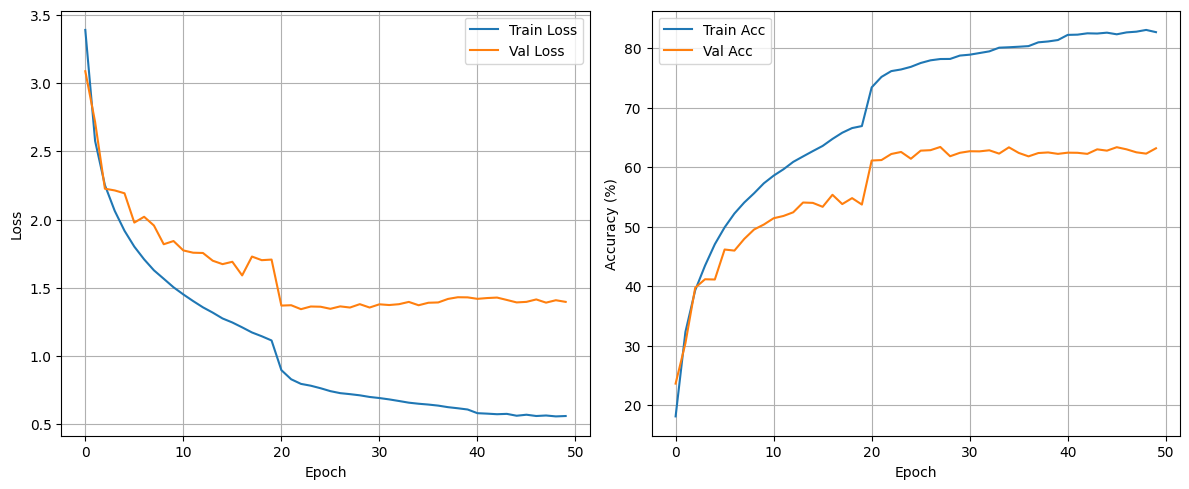


모델 저장 완료:
  Best: vgg16_pruned_remaining_0.3_finetuned_best.pth (Val Acc: 63.42%)
  Final: vgg16_pruned_remaining_0.3_finetuned_final.pth (Test Acc: 63.50%)

Fine-tuning: Remaining Ratio 0.4
프루닝된 모델 로드 완료 (Remaining Ratio: 0.4)
Train: 45000, Validation: 5000

Fine-tuning 설정:
  초기 학습률: 0.01
  학습률 감소 주기: 20 epochs
  학습률 감소 비율: 0.1 (10배 감소)
  Milestones: [20, 40]
  총 Epochs: 50
Epoch 1/50 - Train Loss: 2.7379, Train Acc: 31.42% | Val Loss: 2.2803, Val Acc: 39.00% | LR: 0.010000
Epoch 2/50 - Train Loss: 2.0166, Train Acc: 45.55% | Val Loss: 2.1408, Val Acc: 43.62% | LR: 0.010000
Epoch 3/50 - Train Loss: 1.7377, Train Acc: 52.01% | Val Loss: 2.1583, Val Acc: 43.38% | LR: 0.010000
Epoch 4/50 - Train Loss: 1.5786, Train Acc: 56.12% | Val Loss: 2.3592, Val Acc: 41.32% | LR: 0.010000
Epoch 5/50 - Train Loss: 1.4533, Train Acc: 58.88% | Val Loss: 1.8173, Val Acc: 51.14% | LR: 0.010000
Epoch 6/50 - Train Loss: 1.3462, Train Acc: 61.59% | Val Loss: 1.6476, Val Acc: 54.06% | LR: 0.010000
Epoch 7/5

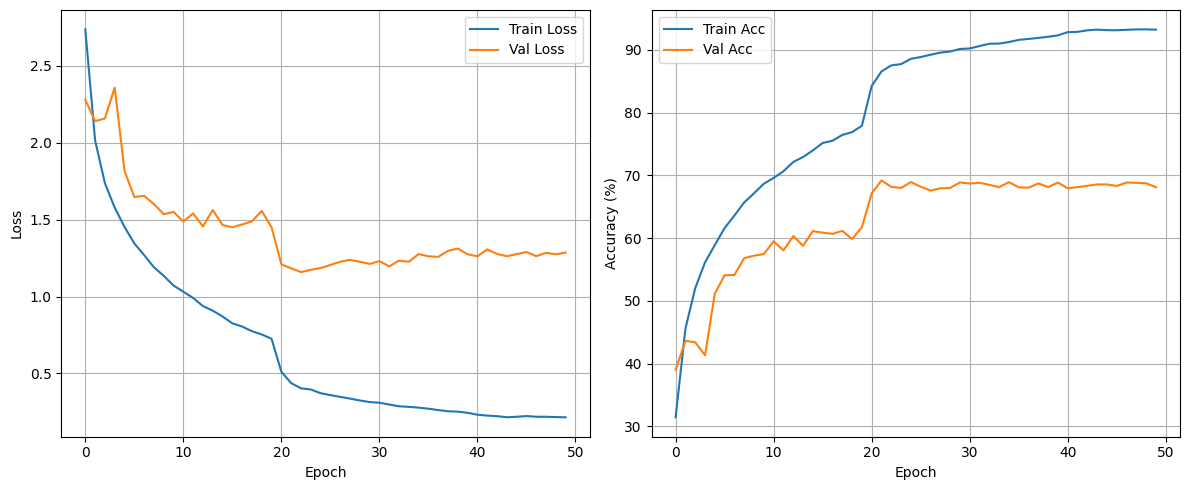


모델 저장 완료:
  Best: vgg16_pruned_remaining_0.4_finetuned_best.pth (Val Acc: 69.18%)
  Final: vgg16_pruned_remaining_0.4_finetuned_final.pth (Test Acc: 67.16%)

Fine-tuning: Remaining Ratio 0.5
프루닝된 모델 로드 완료 (Remaining Ratio: 0.5)
Train: 45000, Validation: 5000

Fine-tuning 설정:
  초기 학습률: 0.01
  학습률 감소 주기: 20 epochs
  학습률 감소 비율: 0.1 (10배 감소)
  Milestones: [20, 40]
  총 Epochs: 50
Epoch 1/50 - Train Loss: 2.2585, Train Acc: 42.08% | Val Loss: 2.1333, Val Acc: 44.24% | LR: 0.010000
Epoch 2/50 - Train Loss: 1.6295, Train Acc: 55.31% | Val Loss: 1.8313, Val Acc: 51.64% | LR: 0.010000
Epoch 3/50 - Train Loss: 1.4007, Train Acc: 60.90% | Val Loss: 1.7409, Val Acc: 53.76% | LR: 0.010000
Epoch 4/50 - Train Loss: 1.2410, Train Acc: 64.74% | Val Loss: 1.7010, Val Acc: 54.50% | LR: 0.010000
Epoch 5/50 - Train Loss: 1.1266, Train Acc: 67.47% | Val Loss: 1.5432, Val Acc: 58.02% | LR: 0.010000
Epoch 6/50 - Train Loss: 1.0316, Train Acc: 70.13% | Val Loss: 1.4202, Val Acc: 61.28% | LR: 0.010000
Epoch 7/5

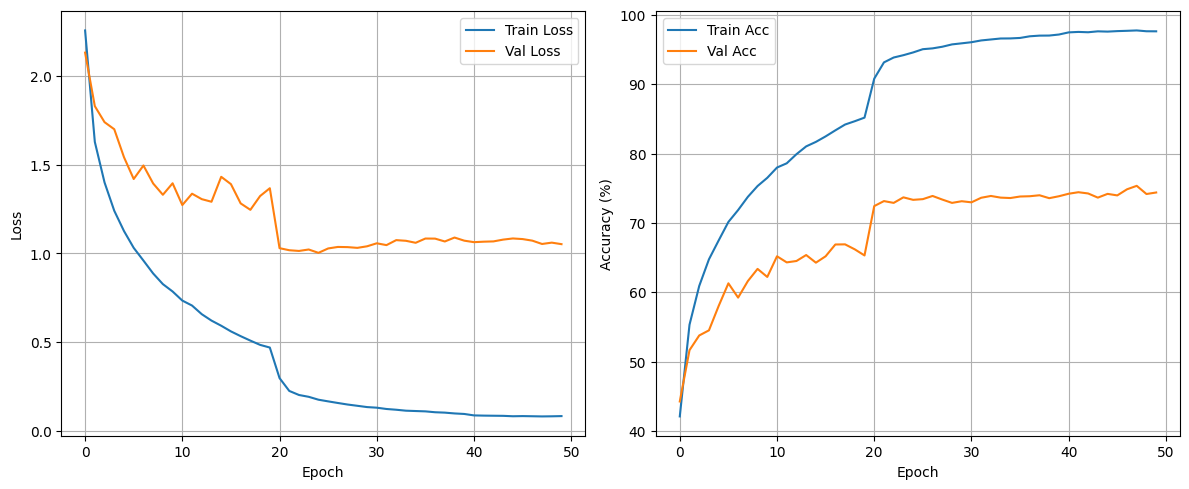


모델 저장 완료:
  Best: vgg16_pruned_remaining_0.5_finetuned_best.pth (Val Acc: 75.34%)
  Final: vgg16_pruned_remaining_0.5_finetuned_final.pth (Test Acc: 69.82%)

Fine-tuning: Remaining Ratio 0.7
프루닝된 모델 로드 완료 (Remaining Ratio: 0.7)
Train: 45000, Validation: 5000

Fine-tuning 설정:
  초기 학습률: 0.01
  학습률 감소 주기: 20 epochs
  학습률 감소 비율: 0.1 (10배 감소)
  Milestones: [20, 40]
  총 Epochs: 50
Epoch 1/50 - Train Loss: 1.4437, Train Acc: 61.27% | Val Loss: 1.4944, Val Acc: 60.26% | LR: 0.010000
Epoch 2/50 - Train Loss: 1.0095, Train Acc: 71.35% | Val Loss: 1.2660, Val Acc: 64.42% | LR: 0.010000
Epoch 3/50 - Train Loss: 0.8423, Train Acc: 75.56% | Val Loss: 1.1285, Val Acc: 68.34% | LR: 0.010000
Epoch 4/50 - Train Loss: 0.7061, Train Acc: 79.06% | Val Loss: 1.1260, Val Acc: 68.50% | LR: 0.010000
Epoch 5/50 - Train Loss: 0.6288, Train Acc: 80.99% | Val Loss: 1.0283, Val Acc: 70.78% | LR: 0.010000
Epoch 6/50 - Train Loss: 0.5531, Train Acc: 83.35% | Val Loss: 1.0091, Val Acc: 70.92% | LR: 0.010000
Epoch 7/5

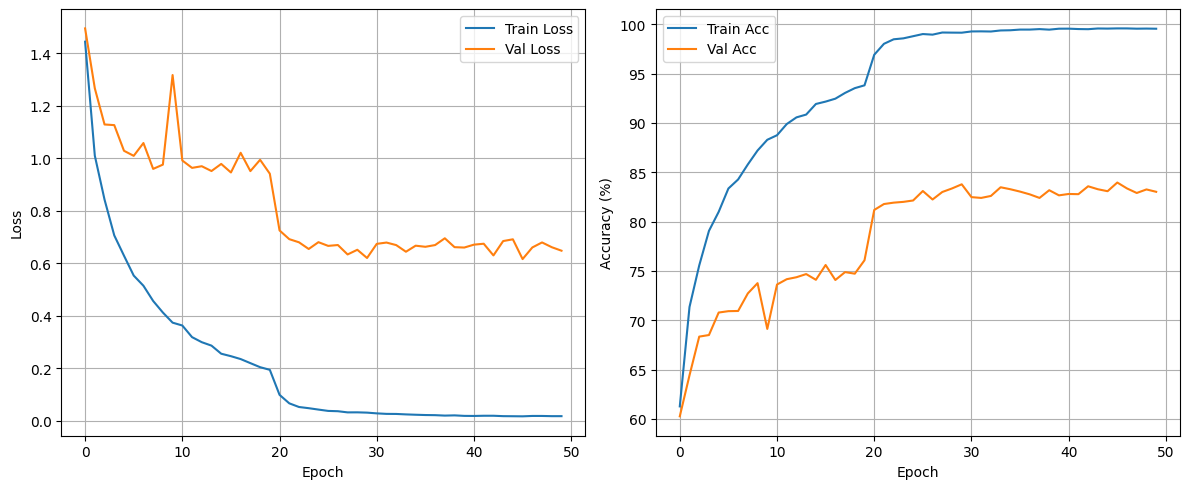


모델 저장 완료:
  Best: vgg16_pruned_remaining_0.7_finetuned_best.pth (Val Acc: 83.96%)
  Final: vgg16_pruned_remaining_0.7_finetuned_final.pth (Test Acc: 72.29%)

모든 Fine-tuning 완료!
Fine-tuned 모델 4개 저장됨


In [9]:
#파인튜닝
finetuned_models = {}

for remaining_ratio in remaining_ratios:
    print(f"\n{'='*80}")
    print(f"Fine-tuning: Remaining Ratio {remaining_ratio}")
    print(f"{'='*80}")

    finetuned_model = finetune(
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        epochs= 50,
        initial_lr=0.01,
        lr_decay_epochs=20,
        lr_decay_factor=0.1,
        weight_decay=0.0001,
        remaining_ratio=remaining_ratio
    )

    finetuned_models[remaining_ratio] = finetuned_model.cpu()
    torch.cuda.empty_cache()

print("\n모든 Fine-tuning 완료!")
print(f"Fine-tuned 모델 {len(finetuned_models)}개 저장됨")

In [12]:
#평가
for remaining_ratio in remaining_ratios:
    pruning_ratio = 1 - remaining_ratio

    print(f"\n{'='*60}")
    print(f"Remaining Ratio: {remaining_ratio} (Pruning Ratio: {pruning_ratio})")
    print(f"{'='*60}")

    model_eval = finetuned_models[remaining_ratio]
    model_eval.eval()
    summary(model_eval, input_size=(1,3,32,32), device=str(device))
    top1, top5 = evaluate(model_eval, test_dataloader, device)
    print(f"TorchScript Loaded → Top-1: {top1:.2f}%  Top-5: {top5:.2f}%")


Remaining Ratio: 0.3 (Pruning Ratio: 0.7)
TorchScript Loaded → Top-1: 63.50%  Top-5: 87.95%

Remaining Ratio: 0.4 (Pruning Ratio: 0.6)
TorchScript Loaded → Top-1: 67.16%  Top-5: 89.61%

Remaining Ratio: 0.5 (Pruning Ratio: 0.5)
TorchScript Loaded → Top-1: 69.82%  Top-5: 90.10%

Remaining Ratio: 0.7 (Pruning Ratio: 0.30000000000000004)
TorchScript Loaded → Top-1: 72.29%  Top-5: 90.97%
